Before running this note book please
do the following terminal commands:
apt-get install gcc
pip install Cython
pip install pycocotools

conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

sys.path.insert(1, '//workspace/dl2020')
#from model_loader_CP2 import *
from CP_helper_RCNN import *
from data_helper_RCNN import *

#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data


 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
#from engine import train_one_epoch, evaluate


#from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2
%load_ext autotime



In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

time: 3.25 ms


In [3]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

time: 1.39 ms


In [4]:
labeled_scene_index_shuf = labeled_scene_index
random.shuffle(labeled_scene_index_shuf)
train_labeled_scene_index = labeled_scene_index_shuf[:-10]
val_labeled_scene_index = labeled_scene_index_shuf[-10:]

time: 2.89 ms


In [5]:
train_labeled_scene_index

array([109, 120, 116, 123, 111, 106, 113, 127, 125, 124, 129, 131, 110,
       108, 128, 112, 117, 126])

time: 8.39 ms


In [6]:
val_labeled_scene_index

array([115, 132, 121, 122, 114, 107, 119, 130, 118, 133])

time: 8.3 ms


In [7]:
# check RCNN dataset
kwargs = {
    #'first_dim': 'sample',
    'transform': None,#transforms.ToTensor(),
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}


dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)

time: 388 ms


In [8]:
len(dataset_train)

2268

time: 4.82 ms


In [9]:
train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

time: 2.33 ms


In [10]:
img = None
tg = None
for i ,(image, target) in enumerate(train_data_loader):
    img = image
    tg = target
    break

time: 508 ms


In [11]:
img[0].shape

torch.Size([6, 3, 256, 306])

time: 4.71 ms


In [12]:
len(img)

1

time: 4.07 ms


In [13]:
img

(tensor([[[[0.6196, 0.6235, 0.6314,  ..., 0.5216, 0.5020, 0.5020],
           [0.6235, 0.6275, 0.6314,  ..., 0.5216, 0.5059, 0.5059],
           [0.6275, 0.6314, 0.6392,  ..., 0.5216, 0.5176, 0.5176],
           ...,
           [0.4902, 0.4980, 0.5059,  ..., 0.4824, 0.4588, 0.4588],
           [0.5333, 0.5412, 0.5490,  ..., 0.4824, 0.4667, 0.4667],
           [0.5529, 0.5569, 0.5647,  ..., 0.4078, 0.4000, 0.4000]],
 
          [[0.8235, 0.8275, 0.8353,  ..., 0.6824, 0.6588, 0.6588],
           [0.8275, 0.8314, 0.8353,  ..., 0.6824, 0.6627, 0.6627],
           [0.8314, 0.8353, 0.8431,  ..., 0.6902, 0.6745, 0.6745],
           ...,
           [0.6588, 0.6667, 0.6745,  ..., 0.6235, 0.6078, 0.6078],
           [0.7059, 0.7137, 0.7216,  ..., 0.6235, 0.6118, 0.6118],
           [0.7294, 0.7333, 0.7412,  ..., 0.5490, 0.5451, 0.5451]],
 
          [[0.9804, 0.9843, 0.9882,  ..., 0.8863, 0.8627, 0.8627],
           [0.9804, 0.9843, 0.9882,  ..., 0.8863, 0.8667, 0.8667],
           [0.9843, 0.98

time: 31.5 ms


In [14]:
toImg = transforms.ToPILImage()
img_ = toImg(img[0][3])

time: 45.6 ms


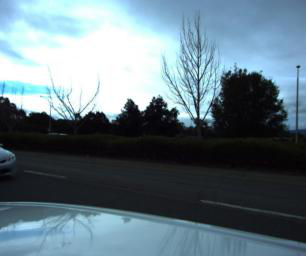

time: 102 ms


In [15]:
img_

In [16]:
tg ##why is the target all the same?

({'boxes': tensor([[ 605.5192, -447.5290,  645.3287, -428.0957],
          [ 667.5043, -306.1984,  706.7552, -288.3299],
          [ 718.6581, -307.9303,  769.4362, -287.9570],
          [ 527.3635, -609.0549,  574.3232, -589.9675],
          [ 289.3147, -444.0886,  336.8097, -425.0475],
          [  39.7886, -407.5276,   87.6314, -386.2040],
          [ 644.1938, -419.4782,  735.9517, -386.8356],
          [ 158.7540, -566.5718,  205.7137, -547.4843]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 

time: 25.7 ms


In [17]:
len(tg[0]["labels"])

8

time: 6.2 ms


In [18]:
len(tg[0]["iscrowd"])

8

time: 5.85 ms


In [19]:
tg[0]["masks"][-1,:,:].sum() 

tensor(940.)

time: 21.1 ms


In [20]:
tempmasks =  torch.as_tensor(tg[0]["masks"][1,:,:], dtype=torch.uint8).numpy()

time: 10.6 ms


In [21]:
type(tempmasks[0][0])

numpy.uint8

time: 12.4 ms


In [22]:
tempmasks2 = (tg[0]["masks"][1]).numpy()

time: 2.38 ms


In [23]:
type(tempmasks2[0][0])

numpy.float32

time: 3.83 ms


In [24]:
torch.tensor([1,2,4])

tensor([1, 2, 4])

time: 4.04 ms


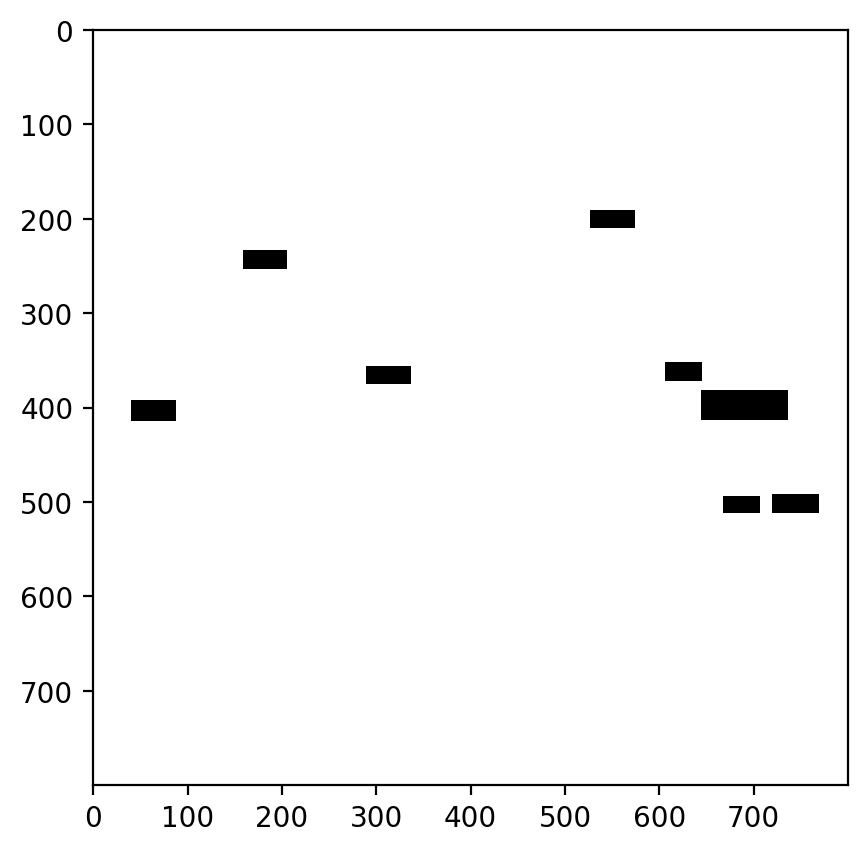

time: 553 ms


In [25]:
fig, ax = plt.subplots()
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(tg[0]["masks"].sum(0), cmap ='binary');

In [26]:
torch.tensor([109])

tensor([109])

time: 4 ms


In [27]:
#verify against original labels
from data_helper import UnlabeledDataset, LabeledDataset

tt = transforms.ToTensor()
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=tt,
                                  extra_info=True
                                 )
LB_trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

time: 299 ms


In [28]:
sample, target, road_image, extra = iter(LB_trainloader).next()

time: 398 ms


In [29]:
len(sample)

1

time: 5.47 ms


In [30]:
sample[0].shape

torch.Size([6, 3, 256, 306])

time: 4.87 ms


In [31]:
type(target)

tuple

time: 4.79 ms


In [32]:
target

({'bounding_box': tensor([[[ 24.4938,  24.5329,  20.5519,  20.5910],
           [  4.7529,   2.8942,   4.6682,   2.8096]],
  
          [[ 30.6383,  30.6755,  26.7504,  26.7877],
           [ -9.3802, -11.0800,  -9.4672, -11.1670]],
  
          [[ 36.9023,  36.9436,  31.8658,  31.9071],
           [ -9.2070, -11.0916,  -9.3197, -11.2043]],
  
          [[ 12.7497,  12.7364,  17.4323,  17.4189],
           [ 18.9967,  20.8698,  19.0325,  20.9055]],
  
          [[ -6.3484,  -6.3190, -11.0685, -11.0391],
           [  4.4089,   2.5830,   4.3306,   2.5047]],
  
          [[-31.3031, -31.2369, -36.0211, -35.9549],
           [  0.7528,  -1.2191,   0.5922,  -1.3796]],
  
          [[ 33.5157,  33.5952,  24.4194,  24.4989],
           [  1.9478,  -1.0730,   1.7044,  -1.3164]],
  
          [[-24.1112, -24.1246, -19.4286, -19.4420],
           [ 14.7484,  16.6215,  14.7842,  16.6572]]], dtype=torch.float64),
  'category': tensor([2, 2, 2, 2, 2, 2, 5, 2])},)

time: 8.48 ms


In [33]:
new_target = trans_target(target)
new_target

({'boxes': tensor([[ 605.5192, -447.5290,  645.3287, -428.0957],
          [ 667.5043, -306.1984,  706.7552, -288.3299],
          [ 718.6581, -307.9303,  769.4362, -287.9570],
          [ 527.3635, -609.0549,  574.3232, -589.9675],
          [ 289.3147, -444.0886,  336.8097, -425.0475],
          [  39.7886, -407.5276,   87.6314, -386.2040],
          [ 644.1938, -419.4782,  735.9517, -386.8356],
          [ 158.7540, -566.5718,  205.7137, -547.4843]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 

time: 25.7 ms


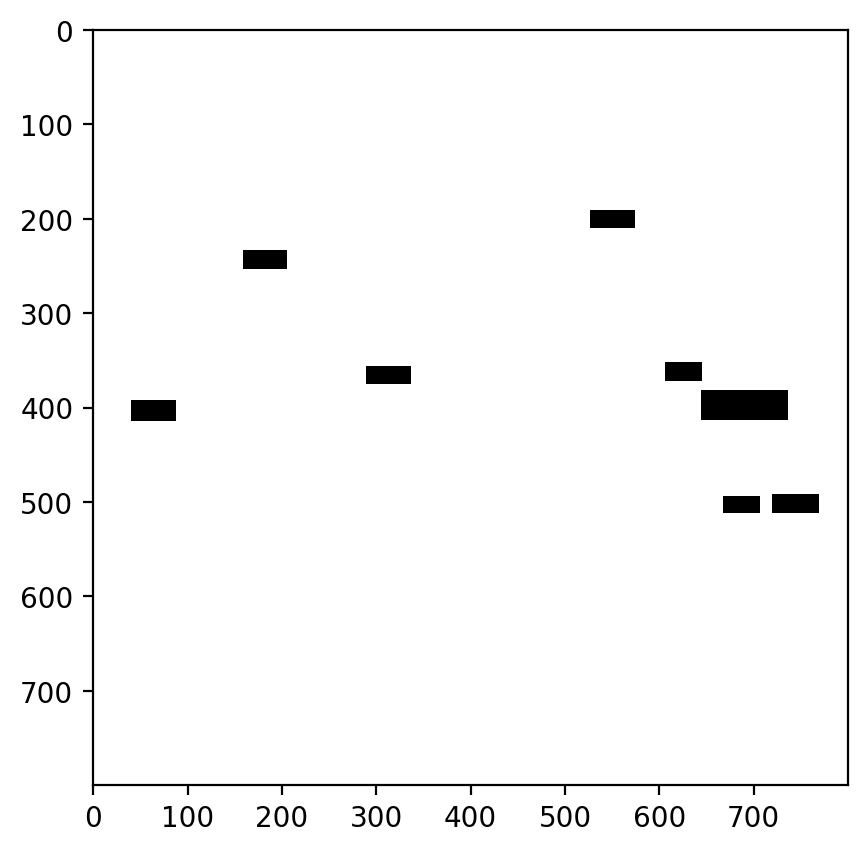

time: 922 ms


In [34]:
fig, ax = plt.subplots()
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(new_target[0]["masks"].sum(0), cmap ='binary');

In [35]:
sample_ = sew_images(sample[0])

time: 52.8 ms


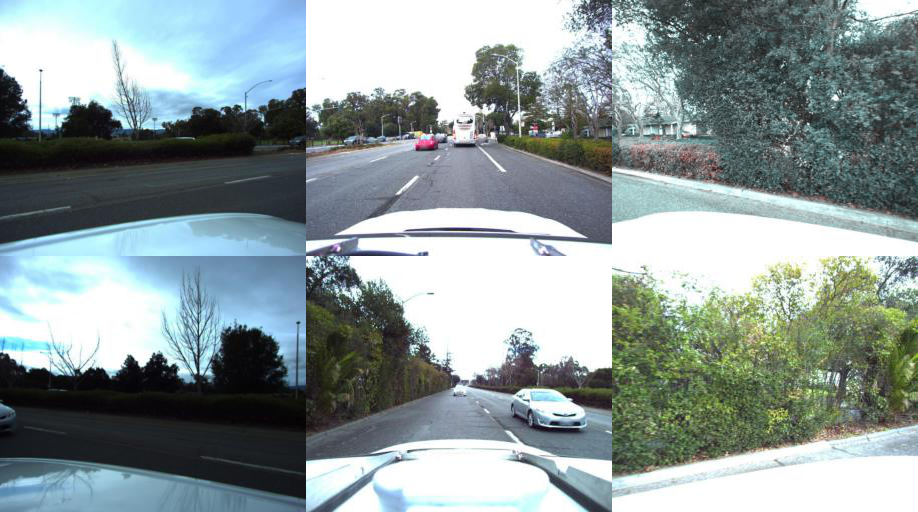

time: 318 ms


In [36]:
sample_

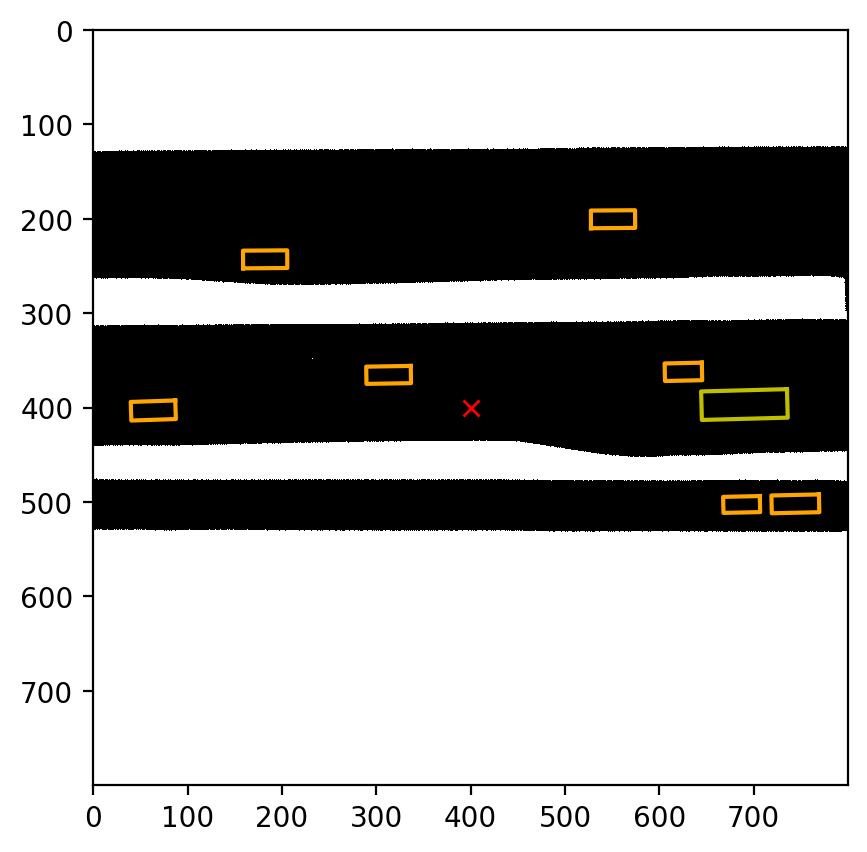

time: 782 ms


In [37]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])
  

In [38]:
#the data is correct
#next try to train 1 epoch

time: 1.87 ms


In [39]:
# load a model pre-trained pre-trained on COCO
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

time: 1.19 ms


In [40]:


 
# # replace the classifier with a new one, that has
# # num_classes which is user-defined
# num_classes = 4  # 4 class none, cars, pedestrian, other 4 broke
# # get number of input features for the classifier
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

time: 1.24 ms


In [41]:
## might need to move this to the helper_RCNN.py
# def get_instance_segmentation_model(num_classes, pretrain = False):
#     # load an instance segmentation model pre-trained on COCO
#     if pretrain:
#         print("in pretrain")
#         model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) #try with pretrained first
#     else: 
#         model = torchvision.models.detection.maskrcnn_resnet50_fpn()
#     # get the number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

#     return model

time: 1.57 ms


In [42]:
#get train and validation loaders
kwargs = {
    #'first_dim': 'sample',
    'transform': transforms.ToTensor(),
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}

#dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)
#dataset_val = LabeledDataset_RCNN (scene_index=val_labeled_scene_index, **kwargs)
 
dataset_train = LabeledDataset(scene_index=train_labeled_scene_index, **kwargs)
dataset_val = LabeledDataset(scene_index=val_labeled_scene_index, **kwargs)

train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

time: 710 ms


In [43]:
val_labeled_scene_index

array([115, 132, 121, 122, 114, 107, 119, 130, 118, 133])

time: 4.54 ms


In [44]:
len(dataset_train)

2268

time: 4.28 ms


In [45]:
len(dataset_val)

1260

time: 4.29 ms


In [46]:
#dsafdsafsd

time: 1.32 ms


In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = CombModel()

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

time: 10.3 s


In [48]:
print(len(train_data_loader))
print(len(val_data_loader))


2268
1260
time: 3.2 ms


In [49]:
# let's train it for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_combModel(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset - this has issues
    #evaluate(model, val_data_loader, device=device)

Epoch: [0]  [   0/2268]  eta: 2:38:44  lr: 0.000100  loss: 33.1961 (33.1961)  loss_classifier: 0.6530 (0.6530)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.8289 (0.8289)  loss_objectness: 0.6886 (0.6886)  loss_rpn_box_reg: 31.0255 (31.0255)  time: 4.1994  data: 0.3936  max mem: 6726
Epoch: [0]  [ 100/2268]  eta: 0:26:41  lr: 0.000100  loss: 18.8284 (28.2401)  loss_classifier: 0.0341 (0.1456)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.1077 (0.2870)  loss_objectness: 0.0249 (0.3201)  loss_rpn_box_reg: 18.5808 (27.4873)  time: 0.7100  data: 0.0070  max mem: 8221
Epoch: [0]  [ 200/2268]  eta: 0:24:32  lr: 0.000100  loss: 13.7754 (21.7509)  loss_classifier: 0.0919 (0.1095)  loss_box_reg: 0.0001 (0.0000)  loss_mask: 0.0514 (0.1780)  loss_objectness: 0.0305 (0.1803)  loss_rpn_box_reg: 13.5907 (21.2831)  time: 0.6966  data: 0.0073  max mem: 8221


KeyboardInterrupt: 

time: 3min 6s


In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_combModel(model, optimizer, train_data_loader, device, epoch, print_freq=500)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset - this has issues
    #evaluate(model, val_data_loader, device=device)

In [ ]:
torch.save({

            'model_state_dict': model.state_dict(),
            #'feat_extractor_state_dict':  feat_extractor.state_dict(),
            #'output_layer_state_dict': output_layer.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
            #'train_losses': train_losses,
            #'val_accs': val_accs
            }, "../models/maskRCNN2_2ep.pt")

In [ ]:
dsafdsafdsa

In [ ]:
# val_data_loader = torch.utils.data.DataLoader(
#     dataset_val, batch_size=1, shuffle=False, num_workers=4,
#     collate_fn=collate_fn)

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = sample
        targets = trans_target(old_targets)
        #print("images len {}, targets len {}".format(len(images), len(targets)))
        #print("images[0] shape {}".format(images[0].shape)) # [6, 3, 256, 306]      
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

In [ ]:
#targets

In [ ]:
images[0].shape

In [ ]:
len(images)

In [ ]:
model.eval()
with torch.no_grad():
    prediction = model(images, None)

In [ ]:
prediction

In [ ]:
images[0]

In [ ]:
newmodel = CombModel().to(device)
newmodel.eval()
with torch.no_grad():
    pred = newmodel(images, None)

In [ ]:
pred

In [ ]:
batch_images = torch.stack(images, 0)

In [ ]:
batch_images.shape

In [ ]:
batch_images = batch_images.cpu()

In [ ]:
a_encode = Encoder()
output = a_encode(batch_images)

In [ ]:
fRCNN_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
fRCNN_model.eval()
x = [torch.rand(1, 800, 800), torch.rand(1, 800, 800)]
predictions = fRCNN_model(x)  

In [ ]:
predictions

In [ ]:
new_target

In [ ]:
x = sample
predictions = fRCNN_model(x)  

In [ ]:
fRCNN_model.forward

In [ ]:
Signature: fRCNN_model.forward(images, targets=None)
Docstring:
Arguments:
    images (list[Tensor]): images to be processed
    targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)

Returns:
    result (list[BoxList] or dict[Tensor]): the output from the model.
        During training, it returns a dict[Tensor] which contains the losses.
        During testing, it returns list[BoxList] contains additional fields
        like `scores`, `labels` and `mask` (for Mask R-CNN models).
File:      ~/miniconda/envs/gpu/lib/python3.7/site-packages/torchvision/models/detection/generalized_rcnn.py
Type:      method

In [ ]:
fRCNN_model

In [ ]:
#  def forward(self, images, targets=None):
#         # type: (List[Tensor], Optional[List[Dict[str, Tensor]]])
#         """
#         Arguments:
#             images (list[Tensor]): images to be processed
#             targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)
#         Returns:
#             result (list[BoxList] or dict[Tensor]): the output from the model.
#                 During training, it returns a dict[Tensor] which contains the losses.
#                 During testing, it returns list[BoxList] contains additional fields
#                 like `scores`, `labels` and `mask` (for Mask R-CNN models).
#         """
#         if self.training and targets is None:
#             raise ValueError("In training mode, targets should be passed")
#         original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])
#         for img in images:
#             val = img.shape[-2:]
#             assert len(val) == 2
#             original_image_sizes.append((val[0], val[1]))

#         images, targets = self.transform(images, targets)
#         features = self.backbone(images.tensors)
#         if isinstance(features, torch.Tensor):
#             features = OrderedDict([('0', features)])
#         proposals, proposal_losses = self.rpn(images, features, targets)
#         detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
#         detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

#         losses = {}
#         losses.update(detector_losses)
#         losses.update(proposal_losses)

#         if torch.jit.is_scripting():
#             if not self._has_warned:
#                 warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
#                 self._has_warned = True
#             return (losses, detections)
#         else:
#             return self.eager_outputs(losses, detections)

In [ ]:
#evaluate(model, val_data_loader, device=device)

In [ ]:
#current numpy version is 1.18.1, need to downgrade to 1.17.5
np.__version__

In [ ]:

#downgrading to Numpy 1.17.5 

In [ ]:
tt = transforms.ToTensor()
val_labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=tt,
                                  extra_info=True
                                 )
LB_valloader = torch.utils.data.DataLoader(val_labeled_trainset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
sample, target, road_image, extra = iter(LB_valloader).next()
sample_ = sew_images(sample[0])
sample_

In [ ]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])
  

In [ ]:
#let's check the output of the predictor
img = None
tg = None
for i ,(image, target) in enumerate(val_data_loader):
    img = image
    tg = target

    break

In [ ]:
img[0].shape

In [ ]:
model.eval()
with torch.no_grad():
    prediction = model([img[0].to(device)])